In [179]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
from scipy import stats


from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold,  StratifiedShuffleSplit

from tqdm.notebook import tqdm ,tnrange
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [180]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [181]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test])

In [182]:
data

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,source
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0.0,train
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0,train
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0.0,train
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0.0,train
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,id_42406,29.0,management,single,tertiary,no,717.0,yes,no,cellular,15,jun,94.0,1.0,NaN,0,unknown,NaN,test
13560,id_14483,NaN,blue-collar,married,secondary,no,604.0,yes,no,telephone,10,jul,155.0,1.0,NaN,0,unknown,NaN,test
13561,id_43066,45.0,blue-collar,married,primary,no,237.0,yes,no,unknown,16,may,231.0,4.0,NaN,0,unknown,NaN,test
13562,id_18375,52.0,admin.,married,primary,no,241.0,yes,no,cellular,13,may,243.0,2.0,299.0,5,failure,NaN,test


In [183]:
data.isna().sum()

id                                      0
customer_age                          889
job_type                                0
marital                               231
education                               0
default                                 0
balance                               580
housing_loan                            0
personal_loan                         223
communication_type                      0
day_of_month                            0
month                                   0
last_contact_duration                 433
num_contacts_in_campaign              157
days_since_prev_campaign_contact    36954
num_contacts_prev_campaign              0
prev_campaign_outcome                   0
term_deposit_subscribed             13564
source                                  0
dtype: int64

In [184]:
data['customer_age'] = data['customer_age'].bfill(axis=0)
data['marital'] = data['marital'].bfill(axis=0)
data['balance'] = data['balance'].fillna(data['balance'].median())
data['personal_loan'] = data['personal_loan'].bfill(axis=0)
data['last_contact_duration'] = data['last_contact_duration'].bfill(axis=0)
data['num_contacts_in_campaign'] = data['num_contacts_in_campaign'].bfill(axis=0)
data['days_since_prev_campaign_contact'] = data['days_since_prev_campaign_contact'].bfill(axis=0)

In [185]:
data['days_since_prev_campaign_contact'] = data['days_since_prev_campaign_contact'].fillna(182.0)

In [186]:
marital = {'married':1, 'single':0, 'divorced':-1}
data['marital'] = data['marital'].map(marital)

In [187]:
education = {'secondary':3, 'tertiary':2, 'primary':1, 'unknown':0}
data['education'] = data['education'].map(education)

In [188]:
default = {'yes':1, 'no':0}
data['default'] = data['default'].map(default)

In [189]:
personal = {'yes':1, 'no':0}
data['personal_loan'] = data['personal_loan'].map(personal)

In [190]:
prev_campaign_outcome = {'success':2, 'failure':0, 'other':0.5, 'unknown':1}
data['prev_campaign_outcome'] = data['prev_campaign_outcome'].map(prev_campaign_outcome)

In [191]:
communication = {'cellular':2, 'unknown':0, 'telephone':1}
data['communication_type'] = data['communication_type'].map(communication)

In [192]:
loan = {'yes':1, 'no':0}
data['housing_loan'] = data['housing_loan'].map(loan)

In [193]:
data = data.drop(columns=['last_contact_duration'], axis=1)

In [194]:
num_cols = ['customer_age', 'balance', 'day_of_month', #'last_contact_duration', 
            'days_since_prev_campaign_contact',  'num_contacts_in_campaign',
           'num_contacts_prev_campaign']
cat_cols = ['job_type', 'month']

In [195]:
num_cols
ss = StandardScaler()
data[num_cols] = ss.fit_transform(data[num_cols])
data

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,source
0,id_43823,-1.158078,management,0,2,0,-0.354929,1,0,0,1.224839,jun,0.400758,-0.786492,-0.251940,1.0,0.0,train
1,id_32289,-0.599654,blue-collar,1,3,0,-0.138314,0,1,2,0.263576,nov,-0.246661,-0.786492,0.182198,0.5,0.0,train
2,id_10523,0.517195,technician,1,3,0,-0.231101,0,0,2,-1.298476,feb,0.400758,-0.543112,-0.251940,1.0,0.0,train
3,id_43951,-0.599654,services,0,3,0,-0.449385,1,0,0,0.503892,may,0.077049,-0.543112,-0.251940,1.0,0.0,train
4,id_40992,0.051841,blue-collar,1,1,0,0.001201,1,0,2,-0.337213,may,-0.246661,-0.543112,-0.251940,1.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,id_42406,-1.065008,management,0,2,0,-0.210741,1,0,2,-0.096898,jun,-0.570371,0.665095,-0.251940,1.0,NaN,test
13560,id_14483,0.424124,blue-collar,1,3,0,-0.248457,1,0,1,-0.697687,jul,-0.570371,0.665095,-0.251940,1.0,NaN,test
13561,id_43066,0.424124,blue-collar,1,1,0,-0.370950,1,0,0,0.023260,may,0.400758,0.665095,-0.251940,1.0,NaN,test
13562,id_18375,1.075620,admin.,1,1,0,-0.369614,1,0,2,-0.337213,may,-0.246661,0.665095,1.918749,0.0,NaN,test


In [196]:
data = pd.get_dummies(columns=cat_cols, data=data)
data

,id,customer_age,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,id_43823,-1.158078,0,2,0,-0.354929,1,0,0,1.224839,...,0,0,0,0,1,0,0,0,0,0
1,id_32289,-0.599654,1,3,0,-0.138314,0,1,2,0.263576,...,0,0,0,0,0,0,0,1,0,0
2,id_10523,0.517195,1,3,0,-0.231101,0,0,2,-1.298476,...,0,1,0,0,0,0,0,0,0,0
3,id_43951,-0.599654,0,3,0,-0.449385,1,0,0,0.503892,...,0,0,0,0,0,0,1,0,0,0
4,id_40992,0.051841,1,1,0,0.001201,1,0,2,-0.337213,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,id_42406,-1.065008,0,2,0,-0.210741,1,0,2,-0.096898,...,0,0,0,0,1,0,0,0,0,0
13560,id_14483,0.424124,1,3,0,-0.248457,1,0,1,-0.697687,...,0,0,0,1,0,0,0,0,0,0
13561,id_43066,0.424124,1,1,0,-0.370950,1,0,0,0.023260,...,0,0,0,0,0,0,1,0,0,0
13562,id_18375,1.075620,1,1,0,-0.369614,1,0,2,-0.337213,...,0,0,0,0,0,0,1,0,0,0


In [197]:
final_test = data[data['source']=='test']
final_train = data[data['source']=='train']

In [198]:
X = final_train.drop(columns=['source', 'term_deposit_subscribed', 'id'], axis=1)
y = final_train['term_deposit_subscribed']

In [199]:
id_test = final_test['id']
final_test = final_test.drop(columns=['source', 'term_deposit_subscribed', 'id'], axis=1)


1 of kfold 10
F1_score 0.9131075110456554

2 of kfold 10
F1_score 0.9121385153803648

3 of kfold 10
F1_score 0.9219547775346464

4 of kfold 10
F1_score 0.9071282337613995

5 of kfold 10
F1_score 0.9151670951156812

6 of kfold 10
F1_score 0.9084222140492828

7 of kfold 10
F1_score 0.9137168141592921

8 of kfold 10
F1_score 0.9103346274727306

9 of kfold 10
F1_score 0.9121771217712177

10 of kfold 10
F1_score 0.9067205288284981


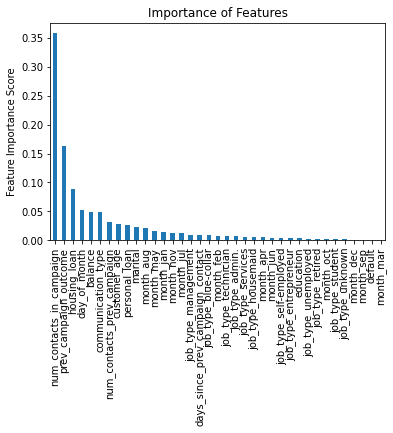

In [201]:
#64.9
i=1
smote=SMOTE()
X, y = smote.fit_sample(X, y)
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = X.loc[train_index],X.loc[test_index]
     ytr,yvl = y[train_index],y[test_index]
     model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=500, subsample=1.0, 
                                        criterion='friedman_mse', min_samples_split=5, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                        min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                        verbose=0, max_leaf_nodes=10, warm_start=False, presort='deprecated', 
                                        validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
     model.fit(xtr, ytr)
     predictors = list(xtr)
     feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
     feat_imp.plot(kind='bar', title='Importance of Features')
     plt.ylabel('Feature Importance Score')
     pred=model.predict(xvl)
     print('F1_score',f1_score(yvl,pred))
     i+=1


1 of kfold 10
F1_score 0.9457092819614711

2 of kfold 10
F1_score 0.9453330989629108

3 of kfold 10
F1_score 0.9437062937062937

4 of kfold 10
F1_score 0.941424802110818

5 of kfold 10
F1_score 0.9426617569700159

6 of kfold 10
F1_score 0.9409090909090908

7 of kfold 10
F1_score 0.9490569363652388

8 of kfold 10
F1_score 0.9464600211342021

9 of kfold 10
F1_score 0.9490569363652388

10 of kfold 10
F1_score 0.9460741261197962


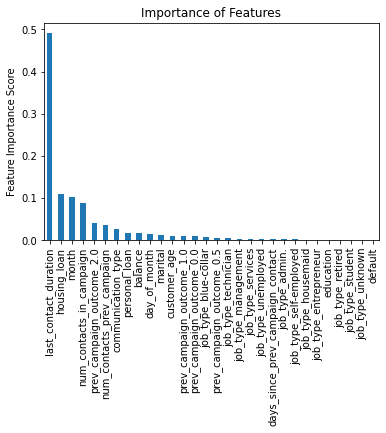

In [140]:
#64.9
i=1
smote=SMOTE()
X, y = smote.fit_sample(X, y)
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = X.loc[train_index],X.loc[test_index]
     ytr,yvl = y[train_index],y[test_index]
     model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=500, subsample=1.0, 
                                        criterion='friedman_mse', min_samples_split=5, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                        min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                        verbose=0, max_leaf_nodes=10, warm_start=False, presort='deprecated', 
                                        validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
     model.fit(xtr, ytr)
     predictors = list(xtr)
     feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
     feat_imp.plot(kind='bar', title='Importance of Features')
     plt.ylabel('Feature Importance Score')
     pred=model.predict(xvl)
     print('F1_score',f1_score(yvl,pred))
     i+=1

In [62]:
#62.9
i=1
smote=SMOTE()
X, y = smote.fit_sample(X, y)
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = X.loc[train_index],X.loc[test_index]
     ytr,yvl = y[train_index],y[test_index]
     model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0, 
                                        criterion='friedman_mse', min_samples_split=5, min_samples_leaf=1, 
                                        min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                        min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                        verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', 
                                        validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
     model.fit(xtr, ytr)
     pred=model.predict(xvl)
     print('F1_score',f1_score(yvl,pred))
     i+=1


1 of kfold 10
F1_score 0.9368621345787926

2 of kfold 10
F1_score 0.9379669852302346

3 of kfold 10
F1_score 0.9367786391042205

4 of kfold 10
F1_score 0.934771264567751

5 of kfold 10
F1_score 0.9373702422145328

6 of kfold 10
F1_score 0.9367875647668393

7 of kfold 10
F1_score 0.9426129426129427

8 of kfold 10
F1_score 0.9370215727209463

9 of kfold 10
F1_score 0.9377391304347826

10 of kfold 10
F1_score 0.9421372719374457


In [167]:
i=1
smote=SMOTE()
X, y = smote.fit_sample(X, y)
kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = X.loc[train_index],X.loc[test_index]
     ytr,yvl = y[train_index],y[test_index]
     model = XGBClassifier(n_estimators=1000,
                           max_depth=6,
                           learning_rate=0.05,
                            subsample=0.9,
                            colsample_bytree=0.35,
                            objective='binary:logistic',
                            random_state=1)
     model.fit(xtr, ytr)
     pred=model.predict(xvl)
     print('F1_score',f1_score(yvl,pred))
     i+=1


1 of kfold 10
F1_score 0.9535954658165073

2 of kfold 10
F1_score 0.9558303886925795

3 of kfold 10
F1_score 0.9581575246132209

4 of kfold 10
F1_score 0.952548950432175

5 of kfold 10
F1_score 0.9546657258775799

6 of kfold 10
F1_score 0.9565981374099456

7 of kfold 10
F1_score 0.9565525802447242

8 of kfold 10
F1_score 0.956367506207875

9 of kfold 10
F1_score 0.9604100388829976

10 of kfold 10
F1_score 0.9560614081524617


In [202]:
sample = pd.read_csv("sample.csv")
sample['id'] = id_test
predictions = model.predict(final_test)
sample['term_deposit_subscribed'] = predictions
#sample['target'] = (probs_lgbm)/4
sample.to_csv('contact.csv',index =False)